In [1]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [41]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [42]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [43]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [44]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [45]:
train_dir = './train2017/'

image_names = os.listdir(train_dir)
print(len(image_names))

%matplotlib inline

119


In [55]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

class Dataset:
    
    def __init__(self, folder):
        self.folder = folder
        self.set_to_use = 0
        
    def get_random_example(self):
        subfolder_name = random.choice(os.listdir(self.folder))
        fname = random.choice(os.listdir(os.path.join(self.folder, subfolder_name)))
        return np.array(Image.open(os.path.join(self.folder, subfolder_name, fname)))
    
    def get_batch(self, use_specific=None):
        to_use = self.set_to_use
        if use_specific is not None:
            to_use = use_specific
            
        subfolder_name = "set_" + str(to_use)
        subfolder_path = os.path.join(self.folder, subfolder_name)
        filenames = os.listdir(subfolder_path)
        
        data = np.empty((len(filenames), H, W, C))
        Xs = np.empty((len(filenames), H, W, C))
        Ys = np.empty((len(filenames), H, W, C-1))
        
        for counter, fname in enumerate(filenames):
            x = np.array(Image.open(os.path.join(subfolder_path, fname)))
            if len(x.shape) == 3:
                cropped = crop_center(x, H, W)
                if cropped is not None:
                    data[counter, :, :, :] = RGBtoYCC(cropped)

        data /= 255
        for counter, x in enumerate(data):
            gray = YCCtoGray(x)
            Xs[counter, :, :, :] = gray
            Ys[counter, :, :, :] = x[:, :, 1:]

        data = None
        if use_specific is None:
            self.set_to_use += 1
        return Xs, Ys

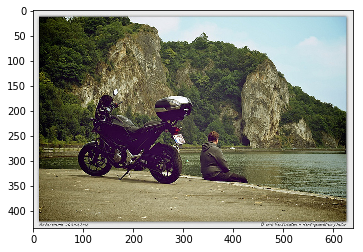

In [56]:
data_folder = "./train2017"
data = Dataset(data_folder)
random_example = data.get_random_example()
imshow(random_example)

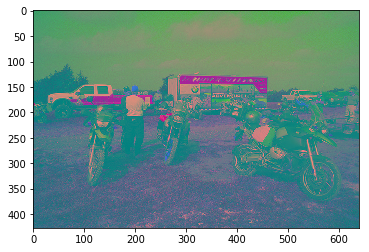

In [49]:
imshow(RGBtoYCC(random_example))

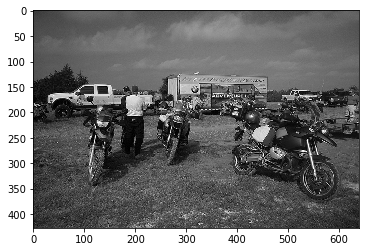

In [50]:
imshow(RGBtoGray(random_example))

In [51]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /cpu:0


In [57]:
model_file = 'model.json'
weights_file = 'weights.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = False
save = True
train = True

In [ ]:
input_shape = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = H // inter1.output_shape[1]
inter2_scale = H // inter2.output_shape[1]
inter3_scale = H // inter3.output_shape[1]
inter4_scale = H // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
print(hyper)

hyper = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
out = tf.keras.layers.Conv2D(2, (3, 3), padding="same")(hyper)

my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
else:
    my_model = tf.keras.models.Model(inputs=model.input, outputs=out)

my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')

num_sets = 4
if train:
    for set_num in range(num_sets):
        X_train, Y_train = data.get_batch()
        history = my_model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=3)
        X_train = None
        Y_train = None

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)




Tensor("up_sampling2d_36/ResizeNearestNeighbor:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("up_sampling2d_37/ResizeNearestNeighbor:0", shape=(?, 256, 256, 128), dtype=float32) Tensor("up_sampling2d_38/ResizeNearestNeighbor:0", shape=(?, 256, 256, 256), dtype=float32) Tensor("up_sampling2d_39/ResizeNearestNeighbor:0", shape=(?, 256, 256, 512), dtype=float32)
Tensor("concatenate_9/concat:0", shape=(?, 256, 256, 960), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_10[0][0]                   
________________________________________________________________

In [ ]:
example_index = 12
single_example = np.expand_dims(X_train[example_index], axis=0)
prediction = my_model.predict(single_example)
prediction = np.reshape(prediction, (64, 64, 2))
print(np.sum((Y_train[example_index] - prediction)**2))
# note that predict and Y_train are both (64, 64, 2) since
# we are only predicting the Cr and Cb components
# to visualize our prediction, have to append in front
# of them the Y channel, X_train[example_index][:, :, 0]

In [ ]:
gray = X_train[example_index][:, :, 0]
imshow(gray, cmap='gray')

In [ ]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
print(prediction.shape)
im = np.zeros_like(X_train[example_index])
im[:, :, 0] = X_train[example_index][:, :, 0]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
imshow(im)

In [ ]:
# converting into RGB gives us
im *= 255
imshow(YCCtoRGB(im))

In [ ]:
should_be = np.zeros_like(X_train[example_index])
should_be[:, :, 0] = X_train[example_index][:, :, 0]
should_be[:, :, 1] = Y_train[example_index][:, :, 0]
should_be[:, :, 2] = Y_train[example_index][:, :, 1]
imshow(should_be)

In [ ]:
# real image
imshow(YCCtoRGB(should_be * 255))

In [ ]:
# here we check loss on validation
batch = X_val
predict = my_model.predict(batch, verbose=True)
truths = Y_val
num_examples = batch.shape[0]
print(predict.shape, truths.shape)
loss_tensor = my_loss_function(tf.keras.backend.variable(predict), tf.keras.backend.variable(truths))
print(tf.keras.backend.eval(loss_tensor))
## double check by doing the calculation in pure numpy
predict_vec = np.reshape(predict, (num_examples, -1))
truths_vec = np.reshape(truths, (num_examples, -1))
all_losses = np.sum((predict_vec - truths_vec)**2, axis=1)
loss_np = np.mean(all_losses, axis=0)
print(loss_np)

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# visualize with validation image
val_index = 10
val_image = np.expand_dims(X_val[val_index], axis=0)
val_prediction = my_model.predict(val_image)
val_prediction = np.reshape(val_prediction, (64, 64, 2))
print(np.sum((Y_val[example_index] - val_prediction)**2))

In [ ]:
gray = X_val[val_index][:, :, 0]
imshow(gray, cmap='gray')

In [ ]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
print(val_prediction.shape)
val_im = np.zeros_like(X_val[val_index])
val_im[:, :, 0] = X_val[val_index][:, :, 0]
val_im[:, :, 1] = val_prediction[:, :, 0]
val_im[:, :, 2] = val_prediction[:, :, 1]
imshow(val_im)

In [ ]:
# converting into RGB gives us
val_im *= 255
imshow(YCCtoRGB(val_im))

In [ ]:
# the real thing is
val_should_be = np.zeros_like(X_val[example_index])
val_should_be[:, :, 0] = X_val[val_index][:, :, 0]
val_should_be[:, :, 1] = Y_val[val_index][:, :, 0]
val_should_be[:, :, 2] = Y_val[val_index][:, :, 1]
imshow(val_should_be)

In [ ]:
# in rgb would be
imshow(YCCtoRGB(255 * val_should_be))